In [44]:
import os
import sys
from pathlib import Path
from typing import List, Tuple, Dict

import IPython
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from lasso.dyna import Binout
from matplotlib.figure import Figure

notebook_path = Path(IPython.extract_module_locals()[1]["__vsc_ipynb_file__"])
project_dir = notebook_path.parent.parent
sys.path.append(str(project_dir))
import src.utils.custom_log as custom_log
from src.utils.local_displacement import get_displ_along_axis
from src.utils.set_rcparams import set_rcparams

os.chdir(project_dir)
LOG = custom_log.init_logger(log_lvl=10, start_msg=f"Start in {Path().cwd()}")

2024-01-30 15:21:55,983 MainProcess  - MainThread      INFO  Start in c:\Users\plaschkies\Documents\Py_Projects\aihiii || custom_log.py


In [45]:
sim_dir: Path = Path(r"Q:\Val_Chain_Sims\Honda_Accord_2014_Original_THOR_2_7\Assemblies_1")
#sim_dir: Path = Path(r"Q:\Val_Chain_Sims\Honda_Accord_2014_Sled_with_HIII_RuntimeMin\Assemblies_1")
cases: List[str] = ["Oblique_Left", "Oblique_Right", "Full_Frontal"]
#cases = [c + "_DR" for c in cases]

In [46]:
node_ids: Dict[str, int] = {
    "B_PillarSillLeft": 82000028,
    "B_PillarSillRight": 82000020,
    "RearSillDriver": 82000012,
    "RearSillPassenger": 82000004,
    "Head": 67100100,  # 67000001
    "Chest": 67700300,  # 67000736,
    "Pelvis": 67800100,  # 67002091,
}

In [47]:
def get_data(binout_dir:Path) -> Tuple[np.ndarray, np.ndarray]:
    """_summary_

    Args:
        d3_dir (Path): directory with binout files

    Returns:
        Tuple[np.ndarray, np.ndarray]: node ids with shape (n_nodes, 1) and node displacements with shape (n_nodes, m_timestamps, o_dimensions)
    """
    LOG.info("Reading binouts from %s", binout_dir)
    binout = Binout(filepath=str(binout_dir / "binout*"))

    ds = np.array([binout.read("nodout", f'{d}_coordinate') for d in "xyz"]).T
    nids = binout.read('nodout', "ids")

    LOG.info("Got node ids shape %s and node coordinates shape %s", nids.shape, ds.shape)

    return nids, ds

In [48]:
data: Dict[str, Tuple[np.ndarray, np.ndarray]] = {c: get_data(binout_dir=sim_dir / c) for c in cases}

2024-01-30 15:21:56,023 MainProcess  - MainThread      INFO  Reading binouts from Q:\Val_Chain_Sims\Honda_Accord_2014_Original_THOR_2_7\Assemblies_1\Oblique_Left || 1403884171.py
2024-01-30 15:21:57,855 MainProcess  - MainThread      INFO  Got node ids shape (111,) and node coordinates shape (111, 1400, 3) || 1403884171.py
2024-01-30 15:21:57,859 MainProcess  - MainThread      INFO  Reading binouts from Q:\Val_Chain_Sims\Honda_Accord_2014_Original_THOR_2_7\Assemblies_1\Oblique_Right || 1403884171.py
2024-01-30 15:21:59,539 MainProcess  - MainThread      INFO  Got node ids shape (111,) and node coordinates shape (111, 1400, 3) || 1403884171.py
2024-01-30 15:21:59,542 MainProcess  - MainThread      INFO  Reading binouts from Q:\Val_Chain_Sims\Honda_Accord_2014_Original_THOR_2_7\Assemblies_1\Full_Frontal || 1403884171.py
2024-01-30 15:22:01,471 MainProcess  - MainThread      INFO  Got node ids shape (110,) and node coordinates shape (110, 1400, 3) || 1403884171.py


In [49]:
LOG.info("Get local displacement driver side")
ds_x_displ_dr: Dict[str, np.ndarray] = {
    case: get_displ_along_axis(
        nodes_coord=data[case][1],
        root_coord=data[case][1][np.nonzero(data[case][0] == node_ids["B_PillarSillLeft"])[0][0], :, :],
        direction_coord=data[case][1][np.nonzero(data[case][0] == node_ids["RearSillDriver"])[0][0], :, :],
        as_displacement=True,
    )
    for case in cases
}
LOG.info("Got local displacement driver side: %s", [(c, ds_x_displ_dr[c].shape) for c in cases])

LOG.info("Get local displacement passenger side")
ds_x_displ_pa: Dict[str, np.ndarray] = {
    case: get_displ_along_axis(
        nodes_coord=data[case][1],
        root_coord=data[case][1][np.nonzero(data[case][0] == node_ids["B_PillarSillRight"])[0][0], :, :],
        direction_coord=data[case][1][np.nonzero(data[case][0] == node_ids["RearSillPassenger"])[0][0], :, :],
        as_displacement=True,
    )
    for case in cases
}
LOG.info("Got local displacement passenger side: %s", [(c, ds_x_displ_pa[c].shape) for c in cases])

2024-01-30 15:22:01,490 MainProcess  - MainThread      INFO  Get local displacement driver side || 2656247635.py
2024-01-30 15:22:01,527 MainProcess  - MainThread      INFO  Got local displacement driver side: [('Oblique_Left', (111, 1400)), ('Oblique_Right', (111, 1400)), ('Full_Frontal', (110, 1400))] || 2656247635.py
2024-01-30 15:22:01,529 MainProcess  - MainThread      INFO  Get local displacement passenger side || 2656247635.py
2024-01-30 15:22:01,565 MainProcess  - MainThread      INFO  Got local displacement passenger side: [('Oblique_Left', (111, 1400)), ('Oblique_Right', (111, 1400)), ('Full_Frontal', (110, 1400))] || 2656247635.py


In [50]:
LOG.info("Get local displacement front side")
ds_y_displ_front: Dict[str, np.ndarray] = {
    case: get_displ_along_axis(
        nodes_coord=data[case][1],
        root_coord=data[case][1][np.nonzero(data[case][0] == node_ids["RearSillDriver"])[0][0], :, :],
        direction_coord=data[case][1][np.nonzero(data[case][0] == node_ids["RearSillPassenger"])[0][0], :, :],
        as_displacement=True,
    )
    for case in cases
}
LOG.info("Got local displacement front side: %s", [(c, ds_y_displ_front[c].shape) for c in cases])

LOG.info("Get local displacement rear side")
ds_y_displ_rear: Dict[str, np.ndarray] = {
    case: get_displ_along_axis(
        nodes_coord=data[case][1],
        root_coord=data[case][1][np.nonzero(data[case][0] == node_ids["B_PillarSillLeft"])[0][0], :, :],
        direction_coord=data[case][1][np.nonzero(data[case][0] == node_ids["B_PillarSillRight"])[0][0], :, :],
        as_displacement=True,
    )
    for case in cases
}
LOG.info("Got local displacement rear side: %s", [(c, ds_y_displ_rear[c].shape) for c in cases])

2024-01-30 15:22:01,579 MainProcess  - MainThread      INFO  Get local displacement front side || 938718979.py
2024-01-30 15:22:01,615 MainProcess  - MainThread      INFO  Got local displacement front side: [('Oblique_Left', (111, 1400)), ('Oblique_Right', (111, 1400)), ('Full_Frontal', (110, 1400))] || 938718979.py
2024-01-30 15:22:01,618 MainProcess  - MainThread      INFO  Get local displacement rear side || 938718979.py
2024-01-30 15:22:01,655 MainProcess  - MainThread      INFO  Got local displacement rear side: [('Oblique_Left', (111, 1400)), ('Oblique_Right', (111, 1400)), ('Full_Frontal', (110, 1400))] || 938718979.py


In [51]:
ds_z_displ_dr: Dict[str, np.ndarray] = {}
ds_z_displ_pa: Dict[str, np.ndarray] = {}

for case in cases:
    LOG.info("Get local displacement driver side")

    root_coord = data[case][1][np.nonzero(data[case][0] == node_ids["B_PillarSillLeft"])[0][0], :, :]
    z_axis = np.cross(
        data[case][1][np.nonzero(data[case][0] == node_ids["RearSillDriver"])[0][0], :, :]
        - data[case][1][np.nonzero(data[case][0] == node_ids["B_PillarSillLeft"])[0][0], :, :],
        data[case][1][np.nonzero(data[case][0] == node_ids["B_PillarSillRight"])[0][0], :, :]
        - data[case][1][np.nonzero(data[case][0] == node_ids["B_PillarSillLeft"])[0][0], :, :],
    )

    z_axis /= np.linalg.norm(z_axis, axis=1)[:, np.newaxis]
    direction_coord = root_coord + z_axis

    ds_z_displ_dr[case] = get_displ_along_axis(
        nodes_coord=data[case][1],
        root_coord=root_coord,
        direction_coord=direction_coord,
        as_displacement=True,
    )

    LOG.info("Get local displacement passenger side")

    root_coord = data[case][1][np.nonzero(data[case][0] == node_ids["B_PillarSillRight"])[0][0], :, :]
    z_axis = np.cross(
        data[case][1][np.nonzero(data[case][0] == node_ids["RearSillPassenger"])[0][0], :, :]
        - data[case][1][np.nonzero(data[case][0] == node_ids["B_PillarSillRight"])[0][0], :, :],
        data[case][1][np.nonzero(data[case][0] == node_ids["B_PillarSillLeft"])[0][0], :, :]
        - data[case][1][np.nonzero(data[case][0] == node_ids["B_PillarSillRight"])[0][0], :, :],
    )

    z_axis /= np.linalg.norm(z_axis, axis=1)[:, np.newaxis]
    direction_coord = root_coord + z_axis

    ds_z_displ_pa[case] = get_displ_along_axis(
        nodes_coord=data[case][1],
        root_coord=root_coord,
        direction_coord=direction_coord,
        as_displacement=True,
    )


LOG.info("Got local displacement driver side: %s", [(c, ds_x_displ_dr[c].shape) for c in cases])
LOG.info("Got local displacement passenger side: %s", [(c, ds_x_displ_pa[c].shape) for c in cases])

2024-01-30 15:22:01,680 MainProcess  - MainThread      INFO  Get local displacement driver side || 4129977480.py
2024-01-30 15:22:01,701 MainProcess  - MainThread      INFO  Get local displacement passenger side || 4129977480.py
2024-01-30 15:22:01,720 MainProcess  - MainThread      INFO  Get local displacement driver side || 4129977480.py
2024-01-30 15:22:01,737 MainProcess  - MainThread      INFO  Get local displacement passenger side || 4129977480.py
2024-01-30 15:22:01,753 MainProcess  - MainThread      INFO  Get local displacement driver side || 4129977480.py
2024-01-30 15:22:01,769 MainProcess  - MainThread      INFO  Get local displacement passenger side || 4129977480.py
2024-01-30 15:22:01,786 MainProcess  - MainThread      INFO  Got local displacement driver side: [('Oblique_Left', (111, 1400)), ('Oblique_Right', (111, 1400)), ('Full_Frontal', (110, 1400))] || 4129977480.py
2024-01-30 15:22:01,790 MainProcess  - MainThread      INFO  Got local displacement passenger side: [('O

c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\lasso\dyna\binout.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(j)] = data.T[i]
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\lasso\dyna\binout.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(j)] = data.T[i]
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\lasso\dyna\binout.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

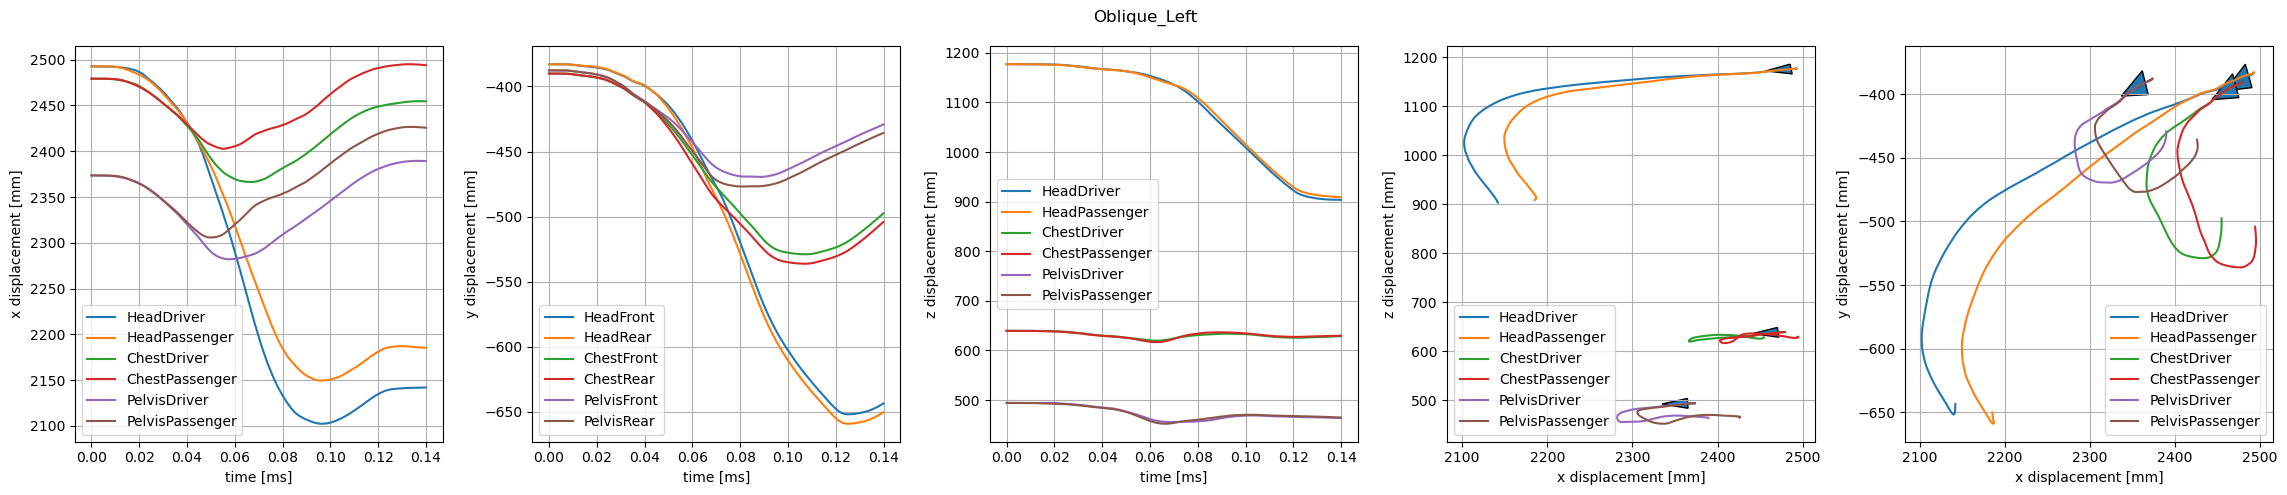

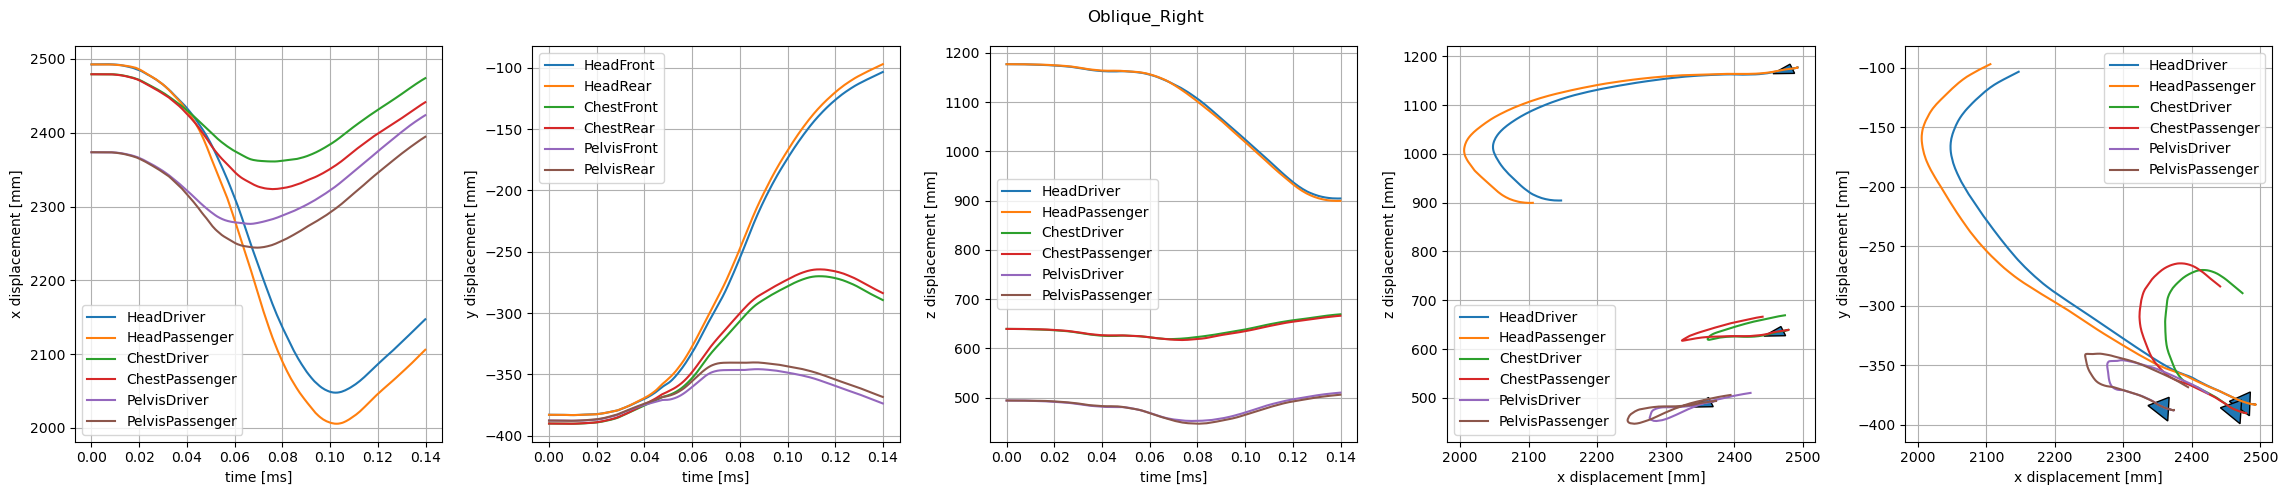

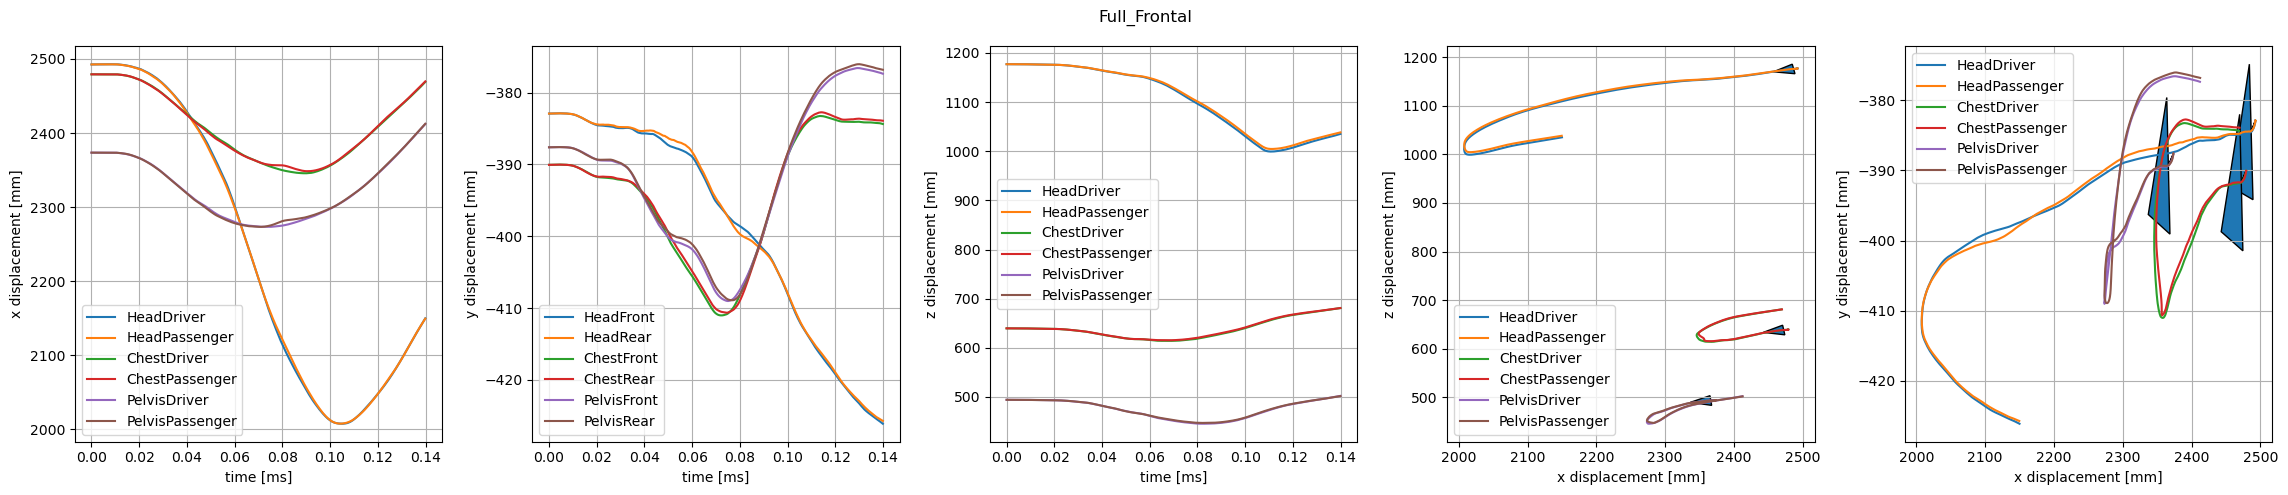

In [52]:
for c in cases:
    fig, ax = plt.subplots(ncols=5, figsize=(23, 5))
    fig.suptitle(c)

    for region in ["Head", "Chest", "Pelvis"]:
        # x
        x0 = Binout(filepath=str(sim_dir / c / "binout*")).as_df("nodout", "x_coordinate")[str(node_ids[region])].iloc[0]
        ax[0].plot(
            Binout(filepath=str(sim_dir / c / "binout*")).read("nodout", "time"),
            x0 - ds_x_displ_dr[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :],
            label=region + "Driver",
        )
        ax[0].plot(
            Binout(filepath=str(sim_dir / c / "binout*")).read("nodout", "time"),
            x0 - ds_x_displ_pa[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :],
            label=region + "Passenger",
        )

        # y
        y0 = Binout(filepath=str(sim_dir / c / "binout*")).as_df("nodout", "y_coordinate")[str(node_ids[region])].iloc[0]
        ax[1].plot(
            Binout(filepath=str(sim_dir / c / "binout*")).read("nodout", "time"),
            y0 - ds_y_displ_front[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :],
            label=region + "Front",
        )
        ax[1].plot(
            Binout(filepath=str(sim_dir / c / "binout*")).read("nodout", "time"),
            y0 - ds_y_displ_rear[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :],
            label=region + "Rear",
        )

        # z
        z0 = Binout(filepath=str(sim_dir / c / "binout*")).as_df("nodout", "z_coordinate")[str(node_ids[region])].iloc[0]
        ax[2].plot(
            Binout(filepath=str(sim_dir / c / "binout*")).read("nodout", "time"),
            z0 + ds_z_displ_dr[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :],
            label=region + "Driver",
        )
        ax[2].plot(
            Binout(filepath=str(sim_dir / c / "binout*")).read("nodout", "time"),
            z0 + ds_z_displ_pa[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :],
            label=region + "Passenger",
        )

        # xz
        ax[3].plot(
            x0 - ds_x_displ_dr[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :],
            z0 + ds_z_displ_dr[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :],
            label=region + "Driver",
        )
        ax[3].plot(
            x0 - ds_x_displ_pa[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :],
            z0 + ds_z_displ_pa[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :],
            label=region + "Passenger",
        )
        ax[3].arrow(
            x0,
            z0,
            -ds_x_displ_dr[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :][200],
            ds_z_displ_dr[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :][200],
            head_width=20,
        )

        # xy
        ax[4].plot(
            x0 - ds_x_displ_dr[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :],
            y0 - ds_y_displ_front[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :],
            label=region + "Driver",
        )
        ax[4].plot(
            x0 - ds_x_displ_pa[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :],
            y0 - ds_y_displ_rear[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :],
            label=region + "Passenger",
        )
        ax[4].arrow(
            x0,
            y0,
            -ds_x_displ_dr[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :][200],
            -ds_y_displ_front[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :][200],
            head_width=20,
        )

    ax[0].grid()
    ax[0].legend()
    ax[0].set_xlabel("time [ms]")
    ax[0].set_ylabel("x displacement [mm]")

    ax[1].grid()
    ax[1].legend()
    ax[1].set_xlabel("time [ms]")
    ax[1].set_ylabel("y displacement [mm]")

    ax[2].grid()
    ax[2].legend()
    ax[2].set_xlabel("time [ms]")
    ax[2].set_ylabel("z displacement [mm]")

    ax[3].grid()
    ax[3].legend()
    ax[3].set_xlabel("x displacement [mm]")
    ax[3].set_ylabel("z displacement [mm]")

    ax[4].grid()
    ax[4].legend()
    ax[4].set_xlabel("x displacement [mm]")
    ax[4].set_ylabel("y displacement [mm]")

    fig.tight_layout()

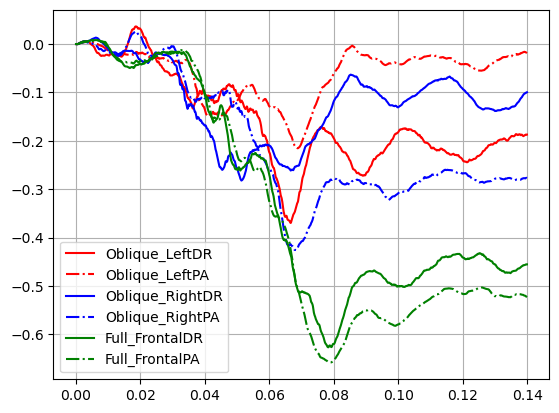

In [53]:
fig, ax = plt.subplots()
cs = ["r", "b", "g"]
for i, case in enumerate(cases):
    dst = (
        data[case][1][np.nonzero(data[case][0] == node_ids["B_PillarSillLeft"])[0][0], :, :]
        - data[case][1][np.nonzero(data[case][0] == node_ids["RearSillDriver"])[0][0], :, :]
    )
    dst = np.linalg.norm(dst, axis=1)
    dst -= dst[0]
    ax.plot(Binout(filepath=str(sim_dir / case / "binout*")).read("nodout", "time"), dst, label=case + "DR", ls="-", c=cs[i])

    dst = (
        data[case][1][np.nonzero(data[case][0] == node_ids["B_PillarSillRight"])[0][0], :, :]
        - data[case][1][np.nonzero(data[case][0] == node_ids["RearSillPassenger"])[0][0], :, :]
    )
    dst = np.linalg.norm(dst, axis=1)
    dst -= dst[0]
    ax.plot(Binout(filepath=str(sim_dir / case / "binout*")).read("nodout", "time"), dst, label=case + "PA", ls="-.", c=cs[i])
ax.legend()
ax.grid()

In [61]:
qq = pd.read_csv(r"C:\Users\plaschkies\Downloads\extracted.csv.zip", index_col=0)
qq

,00COG00000VH00VEXD,00COG00000VH00VEYD,00COG00000VH00ACYD,00COG00000VH00ACXD,01FEMRLE00TH50FORD,01FEMRRI00TH50FORD,01BELTB000VH00DSRD,01BELTB000VH00FORD,01BELTB300VH00FORD,01BELTB400VH00FORD,...,01PELVLOC0TH50DSYD,03HEADLOC0TH50DSYD,03CHSTLOC0TH50DSYD,03PELVLOC0TH50DSYD,01HEADLOC0TH50DSZD,01CHSTLOC0TH50DSZD,01PELVLOC0TH50DSZD,03HEADLOC0TH50DSZD,03CHSTLOC0TH50DSZD,03PELVLOC0TH50DSZD
TIME,,,,,,,,,,,,,,,,,,,,,
0.0,0.0038,0.0036,0.1441,-0.0485,0.0000,0.0000,0.0014,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
0.1,0.0037,0.0038,0.1370,-0.0792,0.0001,0.0001,0.0014,-0.0001,-0.0001,-0.0001,...,-0.0006,-0.0006,-0.0006,-0.0006,0.0001,0.0001,0.0003,0.0002,0.0002,0.0004
0.2,0.0036,0.0039,0.1282,-0.1130,0.0001,0.0001,0.0014,-0.0001,-0.0001,-0.0001,...,-0.0013,-0.0011,-0.0012,-0.0013,0.0002,0.0003,0.0007,0.0004,0.0005,0.0009
0.3,0.0034,0.0040,0.1175,-0.1501,0.0001,0.0001,0.0014,-0.0001,-0.0001,-0.0001,...,-0.0020,-0.0018,-0.0019,-0.0019,0.0003,0.0004,0.0011,0.0007,0.0008,0.0014
0.4,0.0033,0.0041,0.1048,-0.1905,0.0001,0.0001,0.0014,-0.0001,-0.0001,-0.0001,...,-0.0027,-0.0025,-0.0027,-0.0027,0.0004,0.0006,0.0015,0.0009,0.0010,0.0019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139.6,-13.5928,-5.9868,0.5649,-1.5963,0.1315,-0.0253,51.5379,0.3899,0.4534,0.5468,...,42.4489,336.9465,185.0877,58.7475,-266.0983,-8.6833,-28.1127,-391.8133,24.0367,31.3966
139.7,-13.5929,-5.9868,0.5540,-1.6180,0.1313,-0.0251,51.5379,0.3898,0.4540,0.5468,...,42.4309,336.9589,185.0761,58.7486,-266.1057,-8.6819,-28.1188,-391.8293,24.0273,31.3870
139.8,-13.5931,-5.9869,0.5439,-1.6368,0.1312,-0.0249,51.5379,0.3898,0.4545,0.5469,...,42.4153,336.9696,185.0661,58.7496,-266.1121,-8.6807,-28.1241,-391.8431,24.0192,31.3787


c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\lasso\dyna\binout.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(j)] = data.T[i]
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\lasso\dyna\binout.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(j)] = data.T[i]
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\lasso\dyna\binout.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

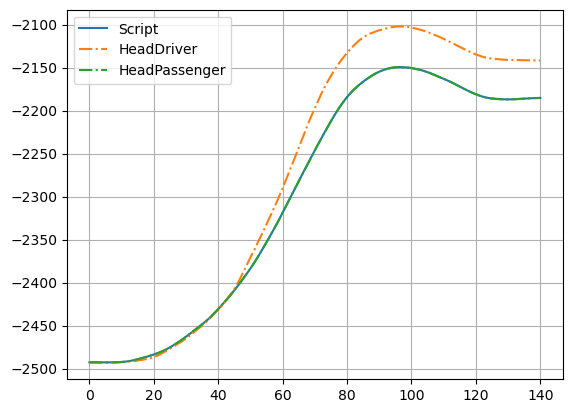

In [67]:
region = "Head"
c = "Oblique_Left"

fig, ax = plt.subplots()
ax.plot(qq.index, qq[f"01{region.upper()}LOC0TH50DSXD"]-qq.loc[0,f"01{region.upper()}0000TH50DSXD"], label="Script")
# x
x0 = Binout(filepath=str(sim_dir / c / "binout*")).as_df("nodout", "x_coordinate")[str(node_ids[region])].iloc[0]
ax.plot(
    Binout(filepath=str(sim_dir / c / "binout*")).read("nodout", "time")*1000,
    -1*(x0 - ds_x_displ_dr[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :]),
    label=region + "Driver",
    ls="-."
)
ax.plot(
    Binout(filepath=str(sim_dir / c / "binout*")).read("nodout", "time")*1000,
    -1*(x0 - ds_x_displ_pa[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :]),
    label=region + "Passenger",
    ls="-."
)

ax.legend()
ax.grid()

c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\lasso\dyna\binout.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(j)] = data.T[i]
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\lasso\dyna\binout.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(j)] = data.T[i]
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\lasso\dyna\binout.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

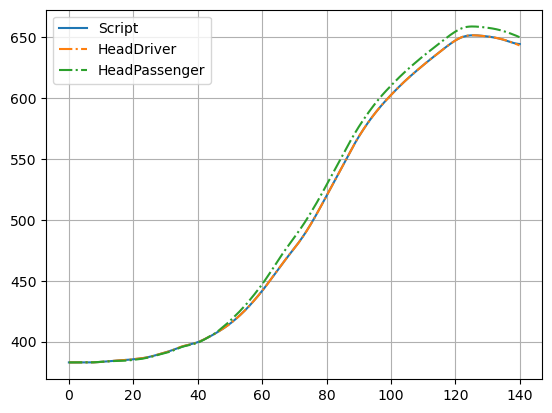

In [69]:
region = "Head"
c = "Oblique_Left"

fig, ax = plt.subplots()
ax.plot(qq.index, qq[f"01{region.upper()}LOC0TH50DSYD"]-qq.loc[0,f"01{region.upper()}0000TH50DSYD"], label="Script")
# x
y0 = Binout(filepath=str(sim_dir / c / "binout*")).as_df("nodout", "y_coordinate")[str(node_ids[region])].iloc[0]
ax.plot(
    Binout(filepath=str(sim_dir / c / "binout*")).read("nodout", "time")*1000,
    -1*(y0 - ds_y_displ_front[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :]),
    label=region + "Driver",
    ls="-."
)
ax.plot(
    Binout(filepath=str(sim_dir / c / "binout*")).read("nodout", "time")*1000,
    -1*(y0 - ds_y_displ_rear[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :]),
    label=region + "Passenger",
    ls="-."
)

ax.legend()
ax.grid()

c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\lasso\dyna\binout.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(j)] = data.T[i]
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\lasso\dyna\binout.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[str(j)] = data.T[i]
c:\Users\plaschkies\Documents\Py_Projects\aihiii\.conda\Lib\site-packages\lasso\dyna\binout.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

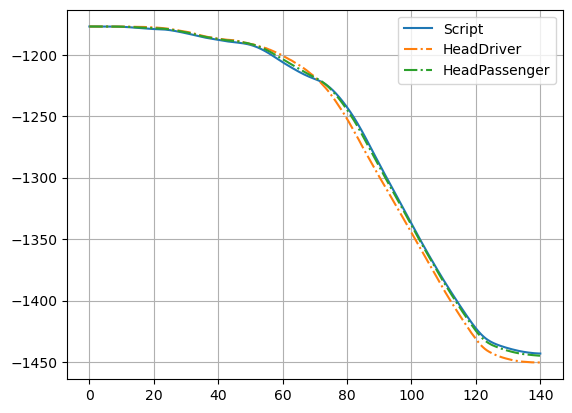

In [70]:
region = "Head"
c = "Oblique_Left"

fig, ax = plt.subplots()
ax.plot(qq.index, qq[f"01{region.upper()}LOC0TH50DSZD"]-qq.loc[0,f"01{region.upper()}0000TH50DSZD"], label="Script")
# x
z0 = Binout(filepath=str(sim_dir / c / "binout*")).as_df("nodout", "z_coordinate")[str(node_ids[region])].iloc[0]
ax.plot(
    Binout(filepath=str(sim_dir / c / "binout*")).read("nodout", "time")*1000,
    -1*(z0 - ds_z_displ_dr[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :]),
    label=region + "Driver",
    ls="-."
)
ax.plot(
    Binout(filepath=str(sim_dir / c / "binout*")).read("nodout", "time")*1000,
    -1*(z0 - ds_z_displ_pa[c][np.nonzero(data[c][0] == node_ids[region])[0][0], :]),
    label=region + "Passenger",
    ls="-."
)

ax.legend()
ax.grid()